In [84]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

## Загрузка данных

Работать мы будем  с датасетом Tourism, который содержит данные о количестве туристов в разных странах — https://zenodo.org/records/4656096.

In [7]:
df = pd.read_csv("monash_tourism_monthly.csv")
df.head()

,id,timestamp,target
0,T000000,1979-01-31,1149.8700
1,T000000,1979-02-28,1053.8002
2,T000000,1979-03-31,1388.8798
3,T000000,1979-04-30,1783.3702
4,T000000,1979-05-31,1921.0252


Для рисования графиков будем использовать Plotly. 

Несколько полезных ссылок:
- Вводная статья про Plotly (на русском): https://habr.com/ru/articles/502958/.

- Галерея графиков с примерами кода: https://plotly.com/python/. 
  
- Time Series and Date Axes in Python: https://plotly.com/python/time-series/.

In [8]:
fig = go.Figure()

seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["timestamp"], y=df[df["id"] == i]["target"], name=str(i))
    )

fig.update_layout(
    title="10 случайных рядов из Monash Tourism Dataset",
    xaxis_title="Дата",
    yaxis_title="Значение ряда",
)

fig.show()

__`Вопросы:`__

__Что можно сказать про эти временные ряды?__
- Различаются ли ряды между собой?

__Выберите какой-то один ряд и посмотрите на него более подробно.__
- Есть ли в нем тренд (линейный, экспоненциальный или какой-то другой)?
- Есть ли в нем сезонность (аддитивная или мультипликативная)?
- Есть ли в нем точки смены режима (точки, в которых сильно меняется поведение ряда)?
- Есть ли в нем выбросы?

## Разделение на обучающую и тестовую выборки

__`Вопрос:`__ __Почему мы не можем просто использовать случайное разбиение на train и test?__

```python
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=True)
```

__`Ответ:`__ 
...

__```Вопрос:```__ __Как изменится наш ответ, если мы уже построили признаки?__

|   | id      | lag_1   | lag_12 | month | year | day | dayofweek |
|---:|---|---|---:|---:|---:|---:|---:|
| 0 | T000000 | NaN | NaN | 1 | 1979 | 31 | 3 |
| 1 | T000000 | 1149.87 | NaN | 2 | 1979 | 28 | 3 |
| 2 | T000000 | 1053.80 | NaN | 3 | 1979 | 31 | 5 |
| ... | ... | ... | ... | ... | ... | ... | ... |

__`Ответ:`__ ...

__`Вопрос:`__ __Почему, даже убрав shuffle, мы получим неверный результат?__

```python
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)
```

__`Ответ:`__ ...

Так как ряды невыровненные, то можно пойти двумя путями:
- Если мы хотим иметь предсказания для каждого ряда, то можно разбить каждый ряд по времени на train и test. Однако тогда в test для одного ряда может попасть такой период, который находится в train другого ряда.

- Мы можем ввести "глобальное" разбиение по времени, но тогда для одних рядов может не оказаться точек в test, а для других — в train.

Так как на этом занятии мы рассматриваем ряды независимо друг от друга, то будем использовать первый подход.

In [9]:
train_ts, test_ts = [], []
for ts_id in df["id"].unique():
    ts_data = df[df["id"] == ts_id].sort_values("timestamp")
    split_index = int(len(ts_data) * 0.8)
    train_ts.append(ts_data.iloc[:split_index])
    test_ts.append(ts_data.iloc[split_index:])
    
train_df = pd.concat(train_ts).reset_index(drop=True)
test_df = pd.concat(test_ts).reset_index(drop=True)

In [10]:
fig = go.Figure()

seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)
colors = px.colors.qualitative.Plotly

for idx, i in enumerate(random_ids):
    color = colors[idx % len(colors)]
    fig.add_trace(
        go.Scatter(
            x=train_df[train_df["id"] == i]["timestamp"],
            y=train_df[train_df["id"] == i]["target"],
            name=f"{i} - train",
            line=dict(color=color),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=test_df[test_df["id"] == i]["timestamp"],
            y=test_df[test_df["id"] == i]["target"],
            name=f"{i} - test",
            line=dict(dash="dash", color=color),
        )
    )

fig.update_layout(
    title="Train и Test выборки для 10 случайных рядов из Monash Tourism Dataset",
    xaxis_title="Дата",
    yaxis_title="Значение ряда",
)
fig.show()

## Метрики

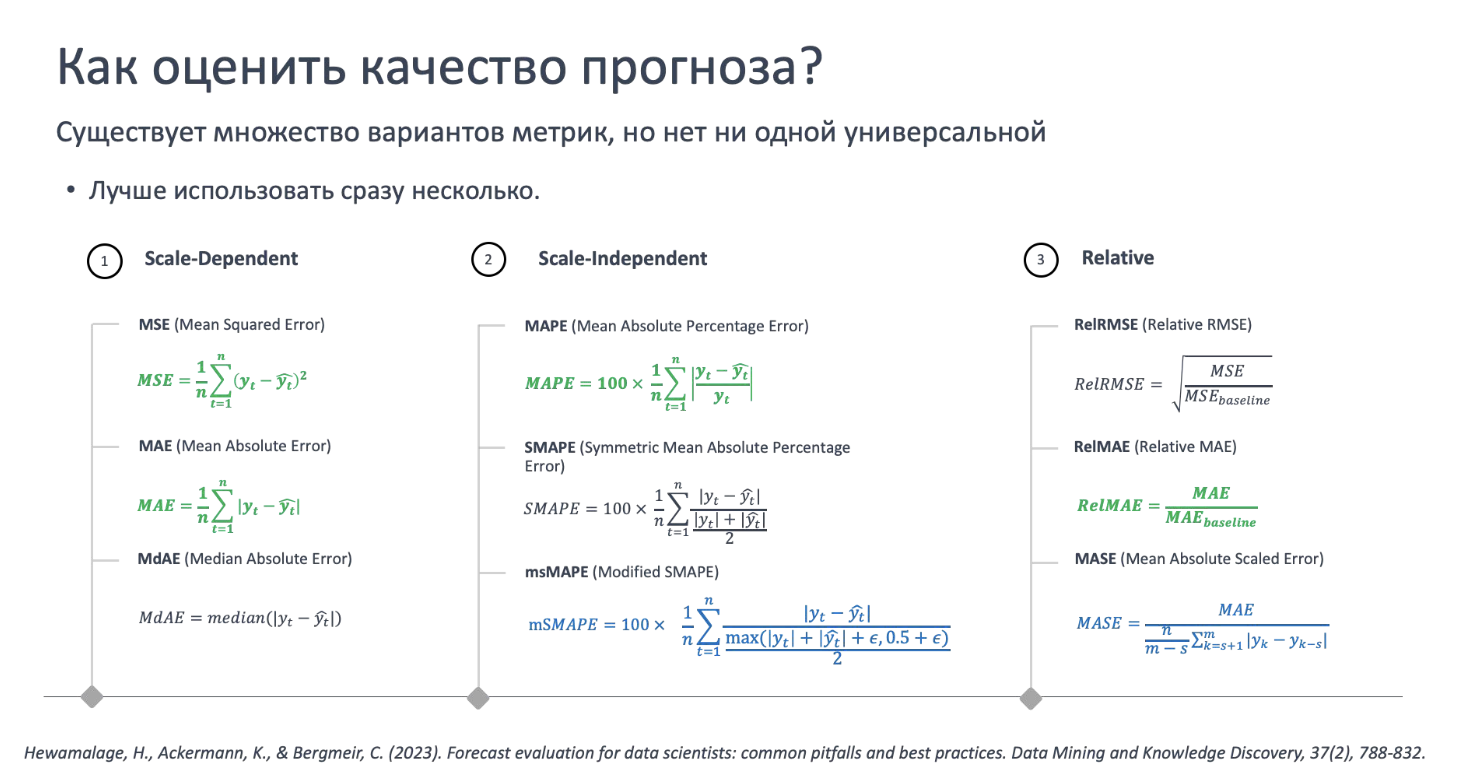

__`Вопрос:`__ __Какие из этих метрик подходят, а какие не подходят для нашей задачи и почему?__

__`Ответ:`__ ...

__`Листочек`__: Какие проблемы решает SMAPE и mSMAPE?

Давайте проверим наличие нулей в наших рядах.

In [11]:
df["target"].value_counts().sort_index()

target
0.0          574
3.0            1
4.0          401
5.0           16
6.0           27
            ... 
1221159.0      1
1238091.0      1
1265519.0      1
1324888.0      1
1364825.0      1
Name: count, Length: 23015, dtype: int64

В качестве упражнения возьмем метрики mSMAPE, RelMAE и MASE для оценки качества наших предсказаний.

In [12]:
def mSMAPE(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    # ♡( •ॢ◡-ॢ)✧˖° ♡ your code here
    numerator = ...
    denominator = ...
    msmape = ...

    return msmape

In [14]:
def RelMAE(y_true: np.ndarray, y_pred: np.ndarray, y_naive: np.ndarray) -> float:
    # ♡( •ॢ◡-ॢ)✧˖° ♡ your code here
    mae_model = ...
    mae_naive = ...
    relmae = ...

    return relmae

In [16]:
def mase(
    y_pred: np.ndarray,
    y_true_insample: np.ndarray,
    y_true_outsample: np.ndarray,
    frequency: int,
) -> float:
    # ♡( •ॢ◡-ॢ)✧˖° ♡ your code here
    mae_model = ...
    mae_naive = ...
    mase = ...

    return mase

## Разложение ряда на компоненты с помощью STL и использование простейших моделей

В иллюстративных целях просемплируем один ряд.

In [18]:
random_id = random.choice(df["id"].unique())
random_train_df = train_df[train_df["id"] == random_id]
random_test_df = test_df[test_df["id"] == random_id]

In [19]:
fig = go.Figure()

seed_everything()
color = px.colors.qualitative.Plotly[0]


fig.add_trace(
    go.Scatter(
        x=train_df[train_df["id"] == random_id]["timestamp"],
        y=train_df[train_df["id"] == random_id]["target"],
        name=f"{random_id} - train",
        line=dict(color=color),
    )
)
fig.add_trace(
    go.Scatter(
        x=test_df[test_df["id"] == random_id]["timestamp"],
        y=test_df[test_df["id"] == random_id]["target"],
        name=f"{random_id} - test",
        line=dict(dash="dash", color=color),
    )
)

fig.update_layout(
    title="Train и Test выборки для случайного ряда из Monash Tourism Dataset",
    xaxis_title="Дата",
    yaxis_title="Значение ряда",
)
fig.show()

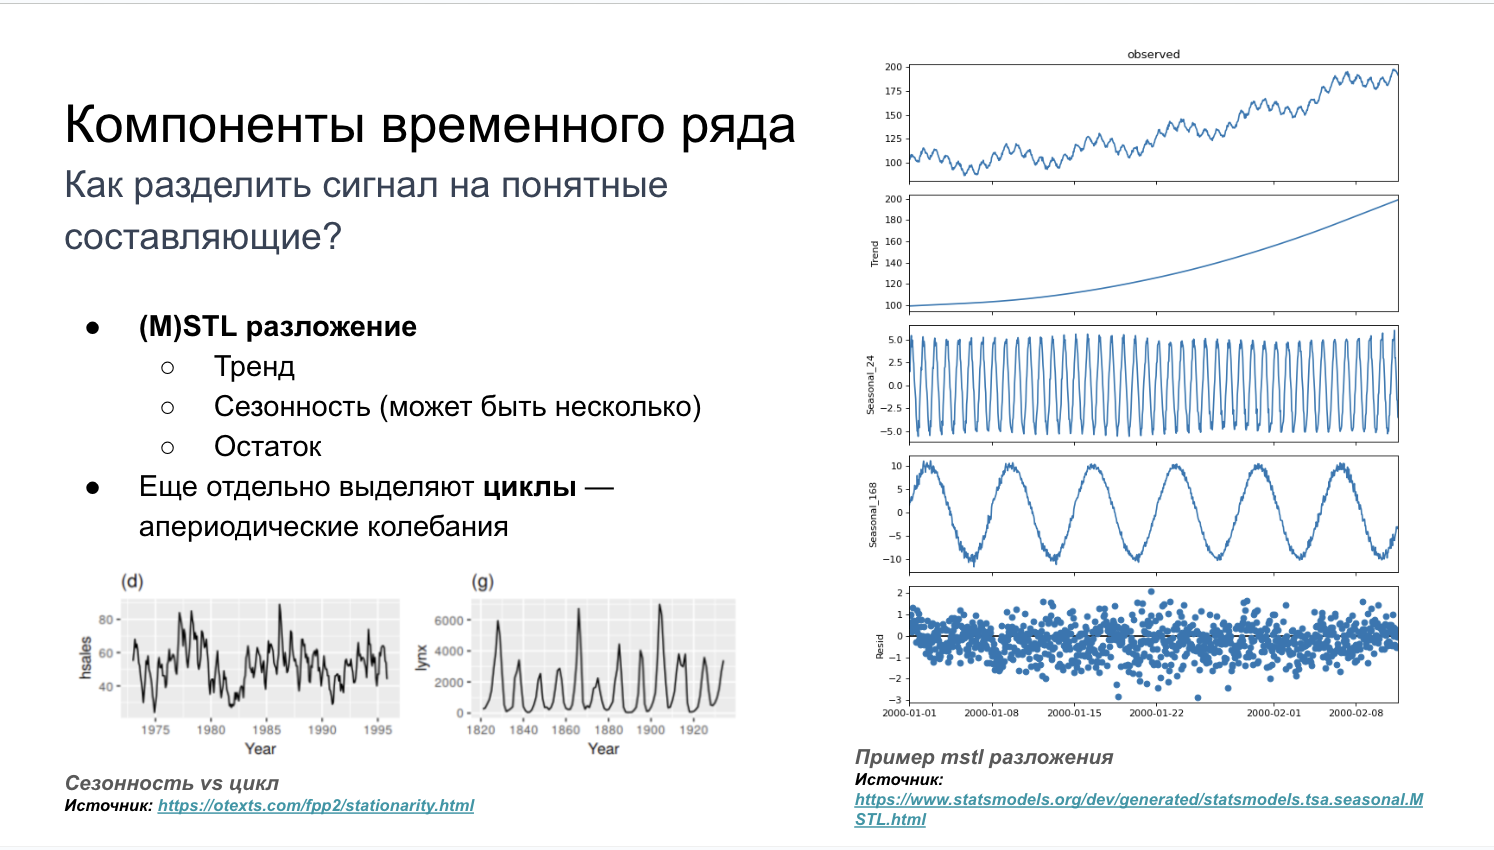

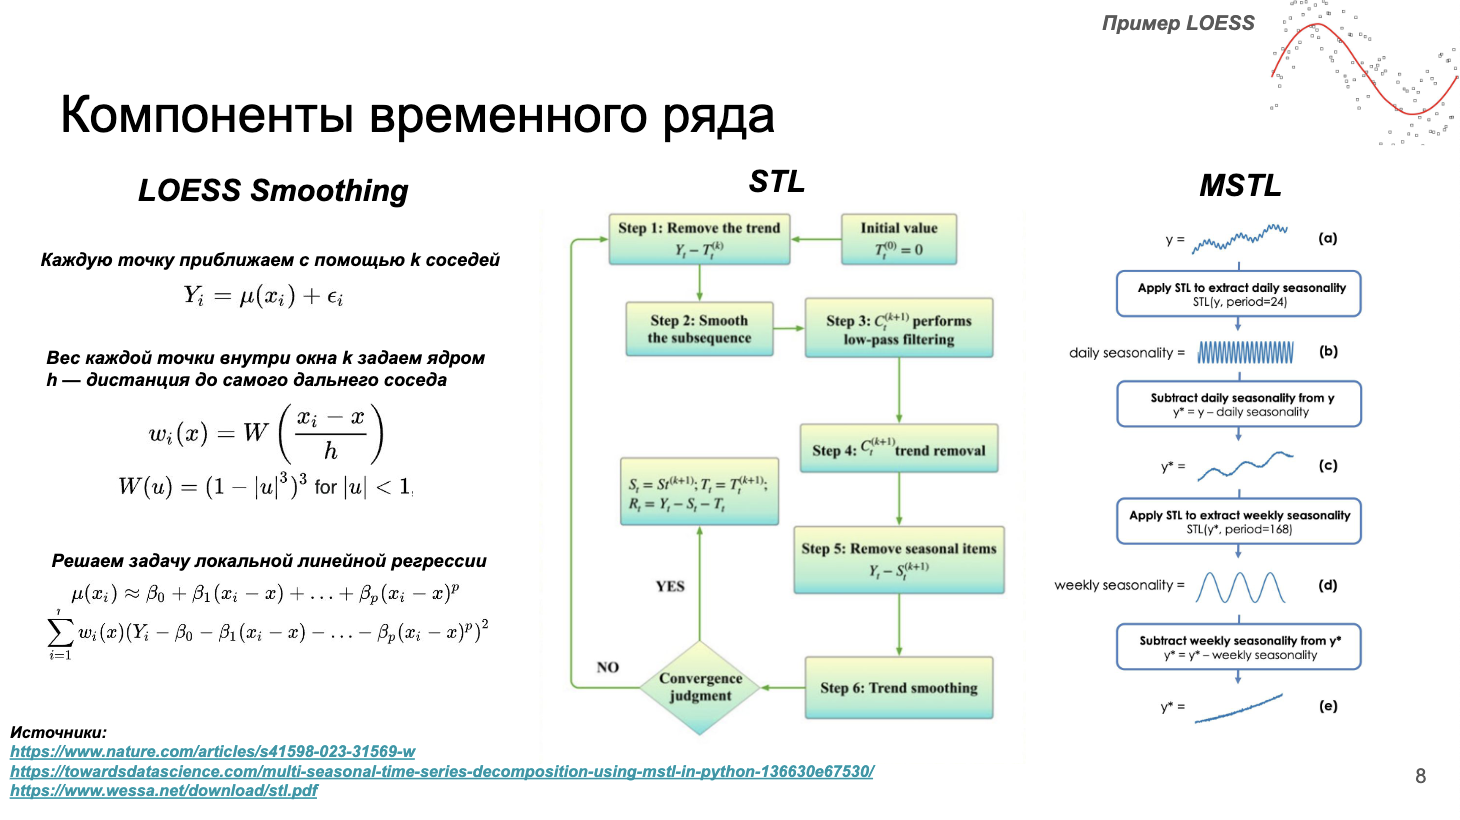

Попробуем выделить явно тренд и сезонность при помощи STL разложения — https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html.

Материалы, которые лучше позволят понять отдельные компоненты STL разложения:
- Алгоритм LOWESS (на русском): http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_LOWESS
  
- Ядровые функции (на русском): http://www.machinelearning.ru/wiki/index.php?title=Ядерное_сглаживание
  
- Метод наименьших квадратов (на русском): https://books.econ.msu.ru/Introduction-to-Econometrics/chap02/2.2/ 

- Метод наименьших квадратов в матричной форме (на русском): https://books.econ.msu.ru/Introduction-to-Econometrics/chap03/3.3/ 
  
- Основные методы декомпозиции и их сравнение: https://otexts.com/fpp3/decomposition.html

Сначала разберемся с тем, как считаем веса для наших точек.

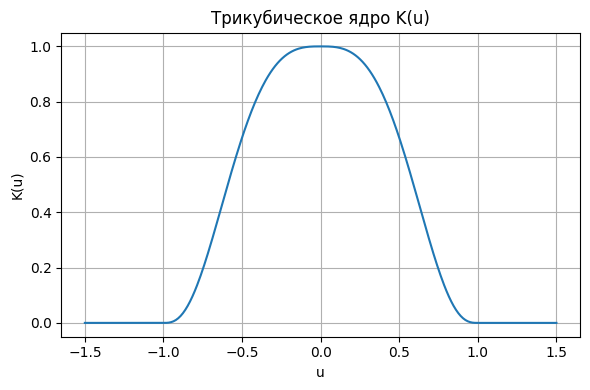

In [ ]:
def tricube_kernel(u: np.ndarray) -> np.ndarray:
    k = np.zeros_like(u)
    mask = np.abs(u) <= 1
    k[mask] = (1 - np.abs(u[mask])**3) ** 3
    return k


u = np.linspace(-1.5, 1.5, 400)
k = tricube_kernel(u)

plt.figure(figsize=(6, 4))
plt.plot(u, k)
plt.title("Трикубическое ядро K(u)")
plt.xlabel("u")
plt.ylabel("K(u)")
plt.grid(True)
plt.tight_layout()
plt.show()

__`Вопрос:`__ __STL разложение требует указания периода. Как его выбрать, исходя из данных?__

Давайте реализуем STL разложение.

Начнем мы с LOESS.

In [23]:
def loess_1d_for_regular_ts(
    y: np.ndarray, num_local_points: int = 7, degree: int = 1
) -> np.ndarray:
    """
    Версия LOESS для одномерного регулярного временного ряда.

    Аргументы:
        y — массив точек
        num_local_points — количество соседей для локального окна
            должно быть нечетным числом
        degree — степень локальной аппроксимации:
            1 — локальная прямая,
            0 — локальная константа
    """
    assert num_local_points % 2 == 1, "num_local_points должно быть нечетным"

    y_length = len(y)

    # y_smooth — пустой массив под сглаженные значения
    y_smooth = np.empty(y_length, dtype=float)

    # Для каждой точки из y нужно найти значение, которое пойдет в y_smooth
    for i in range(y_length):
        # Находим локальное окно вокруг точки x[i]
        # Если точка краевая, то окно будет обрезано
        left = max(0, i - num_local_points // 2)
        right = min(y_length, i + num_local_points // 2 + 1)

        y_local = y[left:right]
        current_num_local_points = len(y_local)

        # Находим расстояния и веса точек в локальном окне
        distances = np.abs(np.arange(left, right) - i)
        u = distances / (np.max(distances) + 1e-8)
        weights = (1 - u**3) ** 3

        # Решаем задачу локальной регрессии
        if degree == 0:  # model: y ~ \beta_0.
            X = np.ones((current_num_local_points, 1))
            X0 = np.array([[1]])
        else:  # model: y ~ \beta_0 + \beta_1 (j - i).
            assert current_num_local_points >= 2, "Для degree=1 нужно минимум 2 точки"
            X = np.vstack([np.ones(current_num_local_points), np.arange(left, right) - i]).T
            X0 = np.array([[1, 0]])

        W = np.diag(weights)
        XtW = X.T @ W
        beta = np.linalg.pinv(XtW @ X) @ XtW @ y_local  # \beta = (X^T W X)^{-1} X^T W y.

        y_smooth[i] = (X0 @ beta).item()

    return y_smooth

In [43]:
y = np.array([1.0, 2.0, 4.0, 3.0, 1.0])
y_smooth = loess_1d_for_regular_ts(y, num_local_points=5, degree=1)
print(y_smooth)

[1.         2.28631052 3.14106845 2.71368948 1.        ]


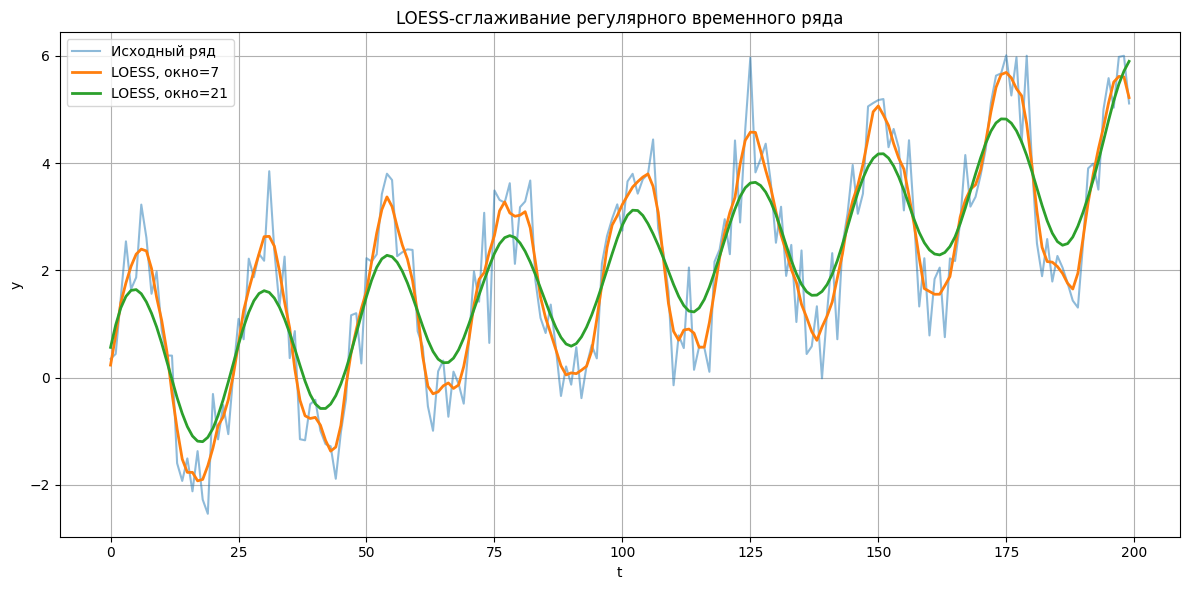

In [38]:
seed_everything()

# Сгенерируем синтетический временной ряд
n = 200
t = np.arange(n)
trend_true = 0.02 * t
season_true = 2 * np.sin(2 * np.pi * t / 24)
noise = np.random.normal(scale=0.7, size=n)
y = trend_true + season_true + noise

# Сглаживание с разными размерами окна
y_smooth_7 = loess_1d_for_regular_ts(y, num_local_points=7, degree=1)
y_smooth_21 = loess_1d_for_regular_ts(y, num_local_points=21, degree=1)

plt.figure(figsize=(12, 6))

plt.plot(t, y, label="Исходный ряд", alpha=0.5)

plt.plot(t, y_smooth_7, label="LOESS, окно=7", linewidth=2)
plt.plot(t, y_smooth_21, label="LOESS, окно=21", linewidth=2)

plt.title("LOESS-сглаживание регулярного временного ряда")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Теперь собираем функции для сглаживания тренда и сезонности.

In [67]:
def estimate_trend_loess(y: np.ndarray, num_local_points: int = 7, degree: int = 1) -> np.ndarray:
    trend = loess_1d_for_regular_ts(y, num_local_points=num_local_points, degree=degree)
    return trend


def lowpass_loess(y: np.ndarray, num_local_points: int, degree: int = 1) -> np.ndarray:
    return loess_1d_for_regular_ts(y, num_local_points=num_local_points, degree=degree)


def estimate_seasonal_loess(
    y_detrended: np.ndarray, period: int, num_local_points: int = 7, degree: int = 1
) -> np.ndarray:
    n = len(y_detrended)

    seasonal = np.zeros(n, dtype=float)

    # Для каждой фазы сезона (0, 1, ..., period-1) берем подпоследовательность и сглаживаем ее
    for phase in range(period):
        idx = np.arange(phase, n, period)
        y_sub = y_detrended[idx]
        y_sub_smooth = loess_1d_for_regular_ts(
            y_sub, num_local_points=num_local_points, degree=degree
        )

        seasonal[idx] += y_sub_smooth

    return seasonal

Наконец, собираем STL пайплайн.

In [74]:
def stl_decompose(
    y: np.ndarray,
    period: int,
    seasonal_num_local_points: int = 7,
    trend_num_local_points: int = 7,
    n_iter: int = 2,
    seasonal_degree: int = 1,
    trend_degree: int = 1,
    lowpass_num_local_points: int | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Step 1: Remove the trend          -> y_detrended = y - T^(k)
    Step 2: Smooth the subsequence    -> S_raw_t
    Step 3: Low-pass filtering        -> C_t = lowpass(S_raw_t)
    Step 4: Trend removal             -> S_t = S_raw_t - C_t
    Step 5: Remove seasonal items     -> y_deseasonal = y - S_t
    Step 6: Trend smoothing           -> T^(k+1)_t
    """
    y = np.asarray(y, dtype=float)
    n = len(y)

    if lowpass_num_local_points is None:
        lowpass_num_local_points = max(7, 3 * period)
        if lowpass_num_local_points % 2 == 0:
            lowpass_num_local_points += 1

    # Инициализация: тренд = 0, сезонность = 0
    trend = np.zeros(n, dtype=float)
    seasonal = np.zeros(n, dtype=float)

    for _ in range(n_iter):
        # Step 1: Remove the trend          -> y_detrended = y - T^(k)
        y_detrended = y - trend
        
        # Step 2: Smooth the subsequence    -> S_raw_t
        seasonal_raw = estimate_seasonal_loess(
            y_detrended,
            period=period,
            num_local_points=seasonal_num_local_points,
            degree=seasonal_degree,
        )
        
        # Step 3: Low-pass filtering        -> C_t = lowpass(S_raw_t)
        seasonal_lowpassed = lowpass_loess(
            seasonal_raw, num_local_points=lowpass_num_local_points, degree=seasonal_degree
        )
        
        # Step 4: Trend removal             -> S_t = S_raw_t - C_t
        seasonal = seasonal_raw - seasonal_lowpassed

        # Step 5: Remove seasonal items     -> y_deseasonal = y - S_t
        y_deseasonal = y - seasonal
        
        # Step 6: Trend smoothing           -> T^(k+1)_t
        trend = estimate_trend_loess(
            y_deseasonal, num_local_points=trend_num_local_points, degree=trend_degree
        )

    # Остаток
    remainder = y - trend - seasonal

    return trend, seasonal, remainder

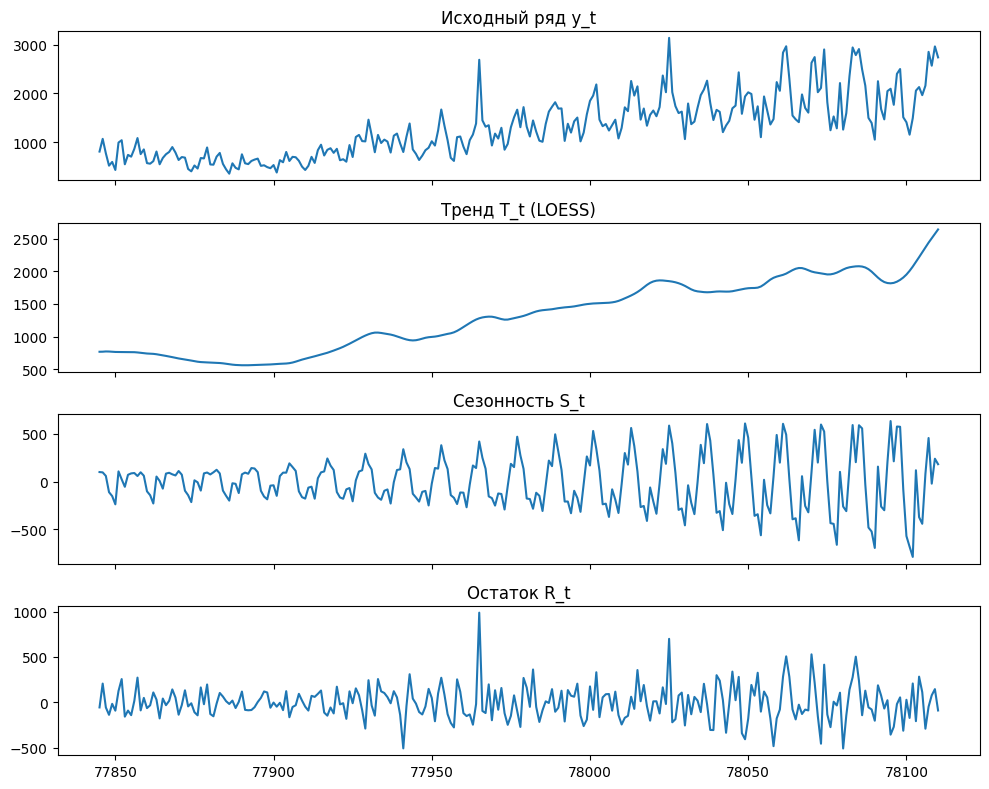

In [79]:
seed_everything()

PERIOD = 12
y = random_train_df["target"].to_numpy()
t = random_train_df.index.to_numpy()

# STL-разложение
trend_num_local_points = int(1.5 * PERIOD / (1 - 1.5 / PERIOD)) + 1

trend, seasonal, remainder = stl_decompose(
    y,
    period=12,
    seasonal_num_local_points=25,
    trend_num_local_points=trend_num_local_points,
    n_iter=10,
    seasonal_degree=1,
    trend_degree=1,
    lowpass_num_local_points=None,
)

# Визуализация
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(t, y)
axes[0].set_title("Исходный ряд y_t")

axes[1].plot(t, trend)
axes[1].set_title("Тренд T_t (LOESS)")

axes[2].plot(t, seasonal)
axes[2].set_title("Сезонность S_t")

axes[3].plot(t, remainder)
axes[3].set_title("Остаток R_t")

plt.tight_layout()
plt.show()

Сравним нашу реализацию с той, что имплементирована в `statsmodels`.

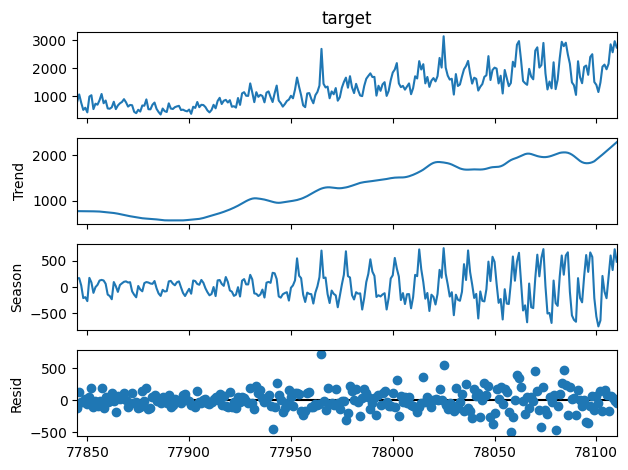

In [ ]:
PERIOD = 12

res = STL(random_train_df["target"], period=PERIOD).fit()
res.plot()
plt.show()

STL-разложение можно использовать для того, чтобы затем строит пайплайны моделей на основое получившихся компонент.

Так, можно тренд и сезонность предсказать простыми моделями, а затем результаты сложить. Остатки можно приблизить ARMA-моделью.

Попробуем сделать первую часть, а именно: построим прогноз тренда методом простого экспоненциального сглаживания, сезонность – наивным повторением последнего цикла, а итоговый прогноз будем считать как сумму тренда и сезонности.

- Про SES: https://otexts.com/fpp3/ses.html

In [108]:
HORIZON = len(random_test_df)

# Генерируем индекс для прогноза
freq = pd.infer_freq(random_train_df["timestamp"])
start = pd.to_datetime(random_train_df["timestamp"].values[-1]) + pd.tseries.frequencies.to_offset(
    freq
)
forecast_index = pd.date_range(start=start, periods=HORIZON, freq=freq)

# Прогноз тренда методом простого экспоненциального сглаживания
trend = res.trend.dropna()
model_trend = SimpleExpSmoothing(trend.to_numpy()).fit()
trend_fc = model_trend.forecast(HORIZON)

# Наивный сезонный прогноз
seasonal = res.seasonal
last_season = seasonal.iloc[-PERIOD:]
seasonal_vals = np.tile(last_season.values, int(np.ceil(HORIZON / PERIOD)))[:HORIZON]
seasonal_fc = pd.Series(seasonal_vals, index=forecast_index)

# Суммируем компоненты и собираем итоговый прогноз
forecast_df = pd.DataFrame({"trend": trend_fc, "seasonal": seasonal_fc})
forecast_df["forecast"] = forecast_df["trend"] + forecast_df["seasonal"]

In [109]:
forecast_df.head()

,trend,seasonal,forecast
2002-03-31,2291.995374,-210.212403,2081.782970
2002-04-30,2291.995374,-561.174117,1730.821256
2002-05-31,2291.995374,-750.120223,1541.875151
2002-06-30,2291.995374,-637.061150,1654.934224
2002-07-31,2291.995374,211.551885,2503.547259


In [110]:
predictions = pd.DataFrame({"date": forecast_df.index, "value": forecast_df["forecast"]})
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=random_train_df["timestamp"], y=random_train_df["target"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=random_test_df["timestamp"], y=random_test_df["target"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Давайте вспомним про наши метрики.

In [112]:
print("mSMAPE:", mSMAPE(random_test_df["target"].to_numpy(), forecast_df["forecast"].to_numpy()))

naive_forecast = random_train_df["target"].to_numpy()[-1:]
naive_forecast = np.tile(naive_forecast, int(np.ceil(HORIZON / 1)))
print(
    "RelMAE:",
    RelMAE(
        random_test_df["target"].to_numpy(),
        forecast_df["forecast"].to_numpy(),
        naive_forecast[:HORIZON],
    ),
)

print(
    "MASE:",
    mase(
        forecast_df["forecast"].to_numpy(),
        random_train_df["target"].to_numpy(),
        random_test_df["target"].to_numpy(),
        frequency=PERIOD,
    ),
)

mSMAPE: 16.334360829202677
RelMAE: 0.6353260279473979
MASE: 1.6445016685943206


Давайте сравним с наивной моделью и сезонной наивной моделью.

In [126]:
seasonal_naive_forecast = random_train_df["target"].to_numpy()[-PERIOD:]
seasonal_naive_forecast = np.tile(seasonal_naive_forecast, int(np.ceil(HORIZON / PERIOD)))[:HORIZON]

In [127]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=random_train_df["timestamp"], y=random_train_df["target"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=random_test_df["timestamp"], y=random_test_df["target"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=seasonal_naive_forecast, name="Seasonal Naive Forecast", line=dict(color="green")
    )
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=naive_forecast, name="Naive Forecast", line=dict(color="orange")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

In [ ]:
pd.DataFrame(
    {
        "Model": ["Decomposition + SES + Seasonal Naive", "Naive", "Seasonal Naive"],
        "mSMAPE": [
            mSMAPE(random_test_df["target"].to_numpy(), forecast_df["forecast"].to_numpy()),
            mSMAPE(random_test_df["target"].to_numpy(), naive_forecast[:HORIZON]),
            mSMAPE(random_test_df["target"].to_numpy(), seasonal_naive_forecast),
        ],
        "RelMAE": [
            RelMAE(
                random_test_df["target"].to_numpy(),
                forecast_df["forecast"].to_numpy(),
                naive_forecast[:HORIZON],
            ),
            RelMAE(
                random_test_df["target"].to_numpy(),
                naive_forecast[:HORIZON],
                naive_forecast[:HORIZON],
            ),
            RelMAE(
                random_test_df["target"].to_numpy(),
                seasonal_naive_forecast,
                naive_forecast[:HORIZON],
            ),
        ],
        "MASE": [
            mase(
                forecast_df["forecast"].to_numpy(),
                random_train_df["target"].to_numpy(),
                random_test_df["target"].to_numpy(),
                frequency=PERIOD,
            ),
            mase(
                naive_forecast[:HORIZON],
                random_train_df["target"].to_numpy(),
                random_test_df["target"].to_numpy(),
                frequency=PERIOD,
            ),
            mase(
                seasonal_naive_forecast,
                random_train_df["target"].to_numpy(),
                random_test_df["target"].to_numpy(),
                frequency=PERIOD,
            ),
        ],
    }
)

,Model,mSMAPE,RelMAE,MASE
0,Decomposition + SES + Seasonal Naive,16.334361,0.635326,1.644502
1,Naive,25.545128,1.000000,2.588437
2,Seasonal Naive,24.541105,0.868749,2.248703
